In [1]:
import numpy as np
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import ExpectationMaximization as EM
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination, BeliefPropagation
import pickle

In [6]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [40]:
output_dir = "D:/Thesis/files_output_dir/output_files/"
ground_truth_level1 = pd.read_csv(output_dir + 'ground_truth_level1_discritize_data.csv')
ground_truth_level2 = pd.read_csv(output_dir + 'ground_truth_level2_discritize_data.csv')
ground_truth_level3 = pd.read_csv(output_dir + 'ground_truth_level3_discritize_data.csv')

# Combine the datasets
combined_data = pd.concat([ground_truth_level1, ground_truth_level2, ground_truth_level3], ignore_index=True)

combined_data['volume_cls'] += 1
combined_data['Day_type'] = combined_data['Day_type'].map({'workday': 0, 'holiday': 1})

# Shuffle the combined data
shuffled_data = shuffle(combined_data, random_state=42)

# Split the data into 50% training and 50% testing datasets
train_data_org, test_data_org = train_test_split(shuffled_data, test_size=0.5, random_state=42)

In [36]:
combined_data['level'].value_counts()

level
2    239
1     86
3     33
Name: count, dtype: int64

In [38]:
combined_data.columns

Index(['road id', 'level', 'lane', 'dir', 'Day_type', 'time_slot', 'speed',
       'volume/min/lane', 'volume_cls', 'theta'],
      dtype='object')

In [41]:
train_data_org.shape

(179, 10)

In [43]:
# Dropping the specified columns
train_data_org = train_data_org.drop(columns=['road id', 'volume/min/lane'])
train_data_org.head()

,level,lane,dir,Day_type,time_slot,speed,volume_cls,theta
190,2,2,1,0,4,1,1,1.0
19,1,3,1,0,4,1,2,2.0
299,2,3,1,0,4,3,3,2.0
332,3,2,2,0,3,2,4,0.0
159,2,3,1,0,3,1,5,1.0


In [44]:
# Dropping the specified columns
test_data_org = test_data_org.drop(columns=['road id', 'volume/min/lane'])
test_data_org.head()


,level,lane,dir,Day_type,time_slot,speed,volume_cls,theta
12,1,2,1,0,3,1,2,1.0
304,2,2,1,0,4,1,2,1.0
215,2,2,1,0,3,2,4,1.0
105,2,3,1,0,4,1,4,1.0
3,1,3,1,0,2,1,1,2.0


In [45]:
train_data = train_data_org.copy()
test_data = test_data_org.copy()

In [27]:
# Define the Bayesian Network structure
model = BayesianNetwork([
    ('level', 'theta'),
    ('Day_type', 'theta'),
    ('lane', 'theta'),
    ('dir', 'theta'),
    ('theta', 'volume_cls'),
    ('theta', 'speed'),
    ('time_slot', 'volume_cls'),
    ('time_slot', 'speed')
])

# Fit the Bayesian Network model on the training data
model.fit(train_data, estimator=MaximumLikelihoodEstimator)

# Make predictions on the test data for the 'volume_cls' column
# Since Bayesian networks in pgmpy do not directly support predict method, 
# we will use the most probable value based on observed evidence.

# inference = VariableElimination(model)
inference = BeliefPropagation(model)

# Predict 'volume_cls' for the test set
predicted_volume_cls = []
for _, row in test_data.iterrows():
    evidence = row.drop('volume_cls').to_dict()  # all other columns are evidence
    
    prediction = inference.map_query(variables=['volume_cls'], evidence=evidence)
    predicted_volume_cls.append(prediction['volume_cls'])

# Convert predictions to a DataFrame
test_data['predicted_volume_cls'] = predicted_volume_cls

# Calculate the true values for 'volume_cls'
true_values = test_data['volume_cls']
predicted_values = test_data['predicted_volume_cls']

# Calculate the error metrics
mae = mean_absolute_error(true_values, predicted_values)
rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
mre = np.mean(np.abs((true_values - predicted_values) / true_values))  # Mean Relative Error

# Display the error metrics
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MRE: {mre}")


d:\Thesis\python_venv\thesis_venv\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
d:\Thesis\python_venv\thesis_venv\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
d:\Thesis\python_venv\thesis_venv\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
d:\Thesis\python_venv\thesis_venv\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
d:\Thesis\python_venv\thesis_venv\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
d:\Thesis\python_venv\the

MAE: 1.2849162011173185
RMSE: 1.691252552261408
MRE: 0.5262569832402235


d:\Thesis\python_venv\thesis_venv\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
d:\Thesis\python_venv\thesis_venv\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
d:\Thesis\python_venv\thesis_venv\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
d:\Thesis\python_venv\thesis_venv\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
d:\Thesis\python_venv\thesis_venv\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


In [28]:
# Get the true and predicted values
true_values = test_data['volume_cls']
predicted_values = test_data['predicted_volume_cls']

# Filter out rows where true_values is 0
non_zero_mask = true_values != 0
true_values_non_zero = true_values[non_zero_mask]
predicted_values_non_zero = predicted_values[non_zero_mask]

# Calculate MRE safely excluding cases where true_values is 0
mre = np.mean(np.abs((true_values_non_zero - predicted_values_non_zero) / true_values_non_zero))

# Calculate the other error metrics (MAE and RMSE) using all data
mae = mean_absolute_error(true_values, predicted_values)
rmse = np.sqrt(mean_squared_error(true_values, predicted_values))

# Print the error metrics
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MRE (excluding zero true values): {mre}")

MAE: 1.2849162011173185
RMSE: 1.691252552261408
MRE (excluding zero true values): 0.5262569832402235


## Level wise Error BN

In [48]:
train_data = train_data_org.copy()
test_data = test_data_org.copy()

In [49]:
# Define the Bayesian Network structure
model = BayesianNetwork([
    ('level', 'theta'),
    ('Day_type', 'theta'),
    ('lane', 'theta'),
    ('dir', 'theta'),
    ('theta', 'volume_cls'),
    ('theta', 'speed'),
    ('time_slot', 'volume_cls'),
    ('time_slot', 'speed')
])

# Fit the Bayesian Network model on the training data
model.fit(train_data, estimator=MaximumLikelihoodEstimator)


# Define a function to calculate error metrics for a specific level using the Bayesian Network
def calculate_errors_for_level_bayesian(level, X_test, y_test, model):
    # Filter data by level
    X_test_level = X_test[X_test['level'] == level]
    y_test_level = y_test[X_test['level'] == level]
    
    # Inference using the Bayesian Network model
    # inference = VariableElimination(model)
    inference = BeliefPropagation(model)
    
    # Predict 'volume_cls' for each row in the test set for the specific level
    predicted_volume_cls = []
    for _, row in X_test_level.iterrows():
        evidence = row.to_dict()  # Use all other columns as evidence except 'volume_cls'  --drop('volume_cls').
        prediction = inference.map_query(variables=['volume_cls'], evidence=evidence)
        predicted_volume_cls.append(prediction['volume_cls'])
    
    # Convert predictions to a series
    y_pred_level = pd.Series(predicted_volume_cls, index=y_test_level.index)
    
    # Calculate the error metrics for the specific level
    mae = mean_absolute_error(y_test_level, y_pred_level)
    rmse = np.sqrt(mean_squared_error(y_test_level, y_pred_level))
    mre = np.mean(np.abs((y_test_level - y_pred_level) / y_test_level))
    
    # Return the calculated errors
    return mae, rmse, mre

# Prepare the test data (excluding 'volume_cls')
X_test = test_data.drop(columns=['volume_cls'])
y_test = test_data['volume_cls']

# Assuming the Bayesian Network model is already trained and defined as `model`

# Calculate errors for level 1
mae_1, rmse_1, mre_1 = calculate_errors_for_level_bayesian(1, X_test, y_test, model)
print(f"Errors for level 1: MAE: {mae_1}, RMSE: {rmse_1}, MRE: {mre_1}")

# Calculate errors for level 2
mae_2, rmse_2, mre_2 = calculate_errors_for_level_bayesian(2, X_test, y_test, model)
print(f"Errors for level 2: MAE: {mae_2}, RMSE: {rmse_2}, MRE: {mre_2}")

# Calculate errors for level 3
mae_3, rmse_3, mre_3 = calculate_errors_for_level_bayesian(3, X_test, y_test, model)
print(f"Errors for level 3: MAE: {mae_3}, RMSE: {rmse_3}, MRE: {mre_3}")


d:\Thesis\python_venv\thesis_venv\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
d:\Thesis\python_venv\thesis_venv\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


Errors for level 1: MAE: 1.1136363636363635, RMSE: 1.5447859516333116, MRE: 0.5390151515151514
Errors for level 2: MAE: 1.2926829268292683, RMSE: 1.684457887269296, MRE: 0.49308943089430896
Errors for level 3: MAE: 1.8333333333333333, RMSE: 2.1984843263788196, MRE: 0.8194444444444445


d:\Thesis\python_venv\thesis_venv\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:488: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


## LR

In [29]:
from sklearn.linear_model import LinearRegression

In [31]:
train_data = train_data_org.copy()
test_data = test_data_org.copy()

In [34]:
train_data = train_data.drop(columns=['road id', 'volume/min/lane'])
test_data = test_data.drop(columns=['road id', 'volume/min/lane'])

In [35]:
# Prepare the data (excluding the target variable 'volume_cls')
X_train = train_data.drop(columns=['volume_cls'])
y_train = train_data['volume_cls']

X_test = test_data.drop(columns=['volume_cls'])
y_test = test_data['volume_cls']

# Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test)

# Calculate the error metrics for Linear Regression
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# # Calculate MRE safely by avoiding division by zero
# epsilon = 1e-10  # A small value to avoid division by zero
# y_test_safe = y_test.replace(0, epsilon)  # Replace zeroes with a small value
mre_lr = np.mean(np.abs((y_test - y_pred_lr) / y_test))

# Print the error metrics for the Linear Regression model
print(f"Linear Regression MAE: {mae_lr}")
print(f"Linear Regression RMSE: {rmse_lr}")
print(f"Linear Regression MRE: {mre_lr}")

# Now you can compare these results to the results from your Bayesian Network model


Linear Regression MAE: 1.2040928388580645
Linear Regression RMSE: 1.388942379470926
Linear Regression MRE: 0.6763547201330169


## Level wise Error

In [51]:
train_data = train_data_org.copy()
test_data = test_data_org.copy()

In [52]:
# Prepare the data (excluding the target variable 'volume_cls')
X_train = train_data.drop(columns=['volume_cls'])
y_train = train_data['volume_cls']

X_test = test_data.drop(columns=['volume_cls'])
y_test = test_data['volume_cls']

# Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Define a function to calculate error metrics for a specific level
def calculate_errors_for_level(level, X_test, y_test, model):
    # Filter data by level
    X_test_level = X_test[X_test['level'] == level]
    y_test_level = y_test[X_test['level'] == level]
    
    # Predict for the specific level using the model
    y_pred_level = model.predict(X_test_level)
    
    # Calculate the error metrics for the specific level
    mae = mean_absolute_error(y_test_level, y_pred_level)
    rmse = np.sqrt(mean_squared_error(y_test_level, y_pred_level))
    
    # Handle MRE safely
    epsilon = 1e-10  # Small value to avoid division by zero
    y_test_level_safe = y_test_level.replace(0, epsilon)
    mre = np.mean(np.abs((y_test_level - y_pred_level) / y_test_level_safe))
    
    # Return the calculated errors
    return mae, rmse, mre

# Prepare the test data (excluding 'volume_cls')
X_test = test_data.drop(columns=['volume_cls'])
y_test = test_data['volume_cls']

# Assuming the Linear Regression model is trained
# You can use your trained model (either BayesianNetwork or Linear Regression) here

# Calculate errors for level 1
mae_1, rmse_1, mre_1 = calculate_errors_for_level(1, X_test, y_test, lr_model)
print(f"Errors for level 1: MAE: {mae_1}, RMSE: {rmse_1}, MRE: {mre_1}")

# Calculate errors for level 2
mae_2, rmse_2, mre_2 = calculate_errors_for_level(2, X_test, y_test, lr_model)
print(f"Errors for level 2: MAE: {mae_2}, RMSE: {rmse_2}, MRE: {mre_2}")

# Calculate errors for level 3
mae_3, rmse_3, mre_3 = calculate_errors_for_level(3, X_test, y_test, lr_model)
print(f"Errors for level 3: MAE: {mae_3}, RMSE: {rmse_3}, MRE: {mre_3}")

Errors for level 1: MAE: 1.242413047756146, RMSE: 1.39983183705407, MRE: 0.726662196722145
Errors for level 2: MAE: 1.1419700155229162, RMSE: 1.3169080238494506, MRE: 0.6123927985003728
Errors for level 3: MAE: 1.7003443454170377, RMSE: 1.9533768646056957, MRE: 1.1475036693741474


## For Bayesian Network level wise error:
Errors for level 1: MAE: 1.1136363636363635, RMSE: 1.5447859516333116, MRE: 0.5390151515151514
Errors for level 2: MAE: 1.2926829268292683, RMSE: 1.684457887269296, MRE: 0.49308943089430896
Errors for level 3: MAE: 1.8333333333333333, RMSE: 2.1984843263788196, MRE: 0.8194444444444445

## For LR level wise error:
Errors for level 1: MAE: 1.242413047756146, RMSE: 1.39983183705407, MRE: 0.726662196722145
Errors for level 2: MAE: 1.1419700155229162, RMSE: 1.3169080238494506, MRE: 0.6123927985003728
Errors for level 3: MAE: 1.7003443454170377, RMSE: 1.9533768646056957, MRE: 1.1475036693741474

| Level   | Model               | MAE     | RMSE    | MRE     |
|---------|---------------------|---------|---------|---------|
| Level 1 | Bayesian Network     | 1.1136  | 1.5448  | 0.5390  |
| Level 1 | Linear Regression    | 1.2424  | 1.3998  | 0.7267  |
| Level 2 | Bayesian Network     | 1.2927  | 1.6845  | 0.4931  |
| Level 2 | Linear Regression    | 1.1420  | 1.3169  | 0.6124  |
| Level 3 | Bayesian Network     | 1.8333  | 2.1985  | 0.8194  |
| Level 3 | Linear Regression    | 1.7003  | 1.9534  | 1.1475  |


In [54]:
import matplotlib.pyplot as plt

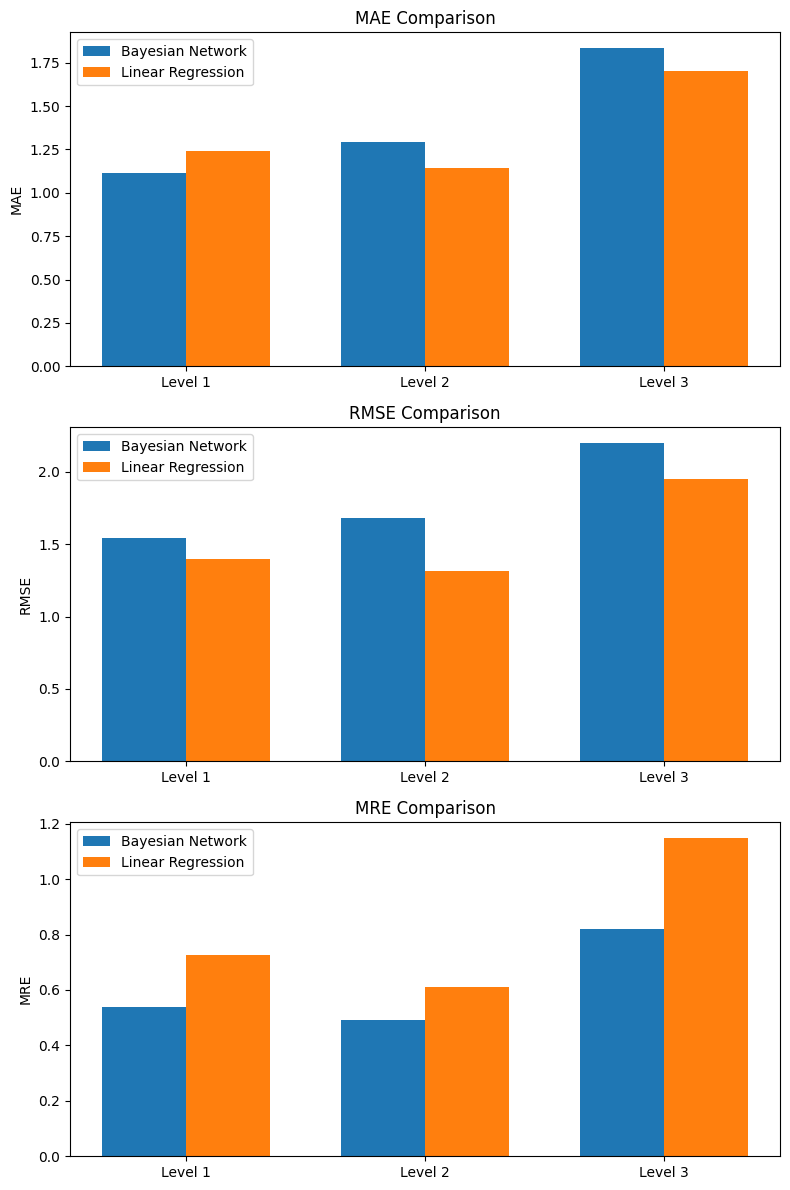

In [55]:
# Data for Bayesian Network errors
bayesian_mae = [1.1136, 1.2927, 1.8333]
bayesian_rmse = [1.5448, 1.6845, 2.1985]
bayesian_mre = [0.5390, 0.4931, 0.8194]

# Data for Linear Regression errors
lr_mae = [1.2424, 1.1420, 1.7003]
lr_rmse = [1.3998, 1.3169, 1.9534]
lr_mre = [0.7267, 0.6124, 1.1475]

# Levels
levels = ['Level 1', 'Level 2', 'Level 3']

# Set up the figure for bar charts
fig, ax = plt.subplots(3, 1, figsize=(8, 12))

bar_width = 0.35  # Width of the bars
index = np.arange(len(levels))  # The label locations

# Plot MAE comparison as a bar chart
ax[0].bar(index, bayesian_mae, bar_width, label='Bayesian Network')
ax[0].bar(index + bar_width, lr_mae, bar_width, label='Linear Regression')
ax[0].set_title('MAE Comparison')
ax[0].set_ylabel('MAE')
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(levels)
ax[0].legend()

# Plot RMSE comparison as a bar chart
ax[1].bar(index, bayesian_rmse, bar_width, label='Bayesian Network')
ax[1].bar(index + bar_width, lr_rmse, bar_width, label='Linear Regression')
ax[1].set_title('RMSE Comparison')
ax[1].set_ylabel('RMSE')
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(levels)
ax[1].legend()

# Plot MRE comparison as a bar chart
ax[2].bar(index, bayesian_mre, bar_width, label='Bayesian Network')
ax[2].bar(index + bar_width, lr_mre, bar_width, label='Linear Regression')
ax[2].set_title('MRE Comparison')
ax[2].set_ylabel('MRE')
ax[2].set_xticks(index + bar_width / 2)
ax[2].set_xticklabels(levels)
ax[2].legend()

# Show the bar charts
plt.tight_layout()
plt.show()
